<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/06_GNN_GIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Isomorphism Networks (GIN) Tutorial for Chemists and Pharmacists

## Introduction

Graph Isomorphism Networks (GINs) are a powerful class of Graph Neural Networks designed to maximize the discriminative power when differentiating graph structures. This makes them particularly valuable for molecular applications, where subtle structural differences between molecules can lead to completely different chemical properties.

In this tutorial, we'll explore GINs with a specific focus on:
1. Understanding the theoretical foundations of GINs and their discriminative power
2. Implementing GINs for molecular property prediction
3. Using GINs for molecular fingerprinting and similarity search
4. Comparing GIN performance with other GNN architectures (GCN, GAT)

## Setup and Requirements

First, let's install the necessary packages:

In [1]:
#@title Intstall necessary libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q rdkit
!pip install -q networkx

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 28.7 MB/s eta 0:00:00


In [2]:
#@title Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, GCNConv, GATConv
from torch_geometric.nn import global_add_pool, global_max_pool, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
import io
from PIL import Image
import random
from IPython.display import HTML

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Understanding Molecular Graphs and Isomorphism

Before diving into GINs, let's first understand what graph isomorphism means in the context of molecular graphs.

Isomorphic Molecules (Same Structure, Different Representation):

2-methylbutane - CC(C)CC


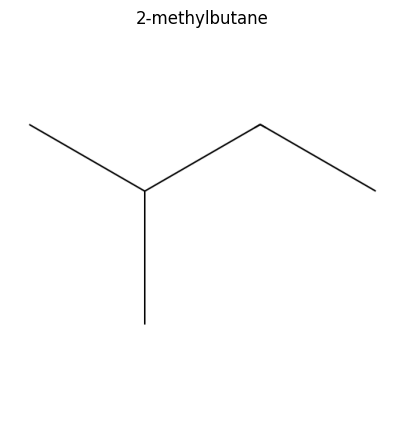

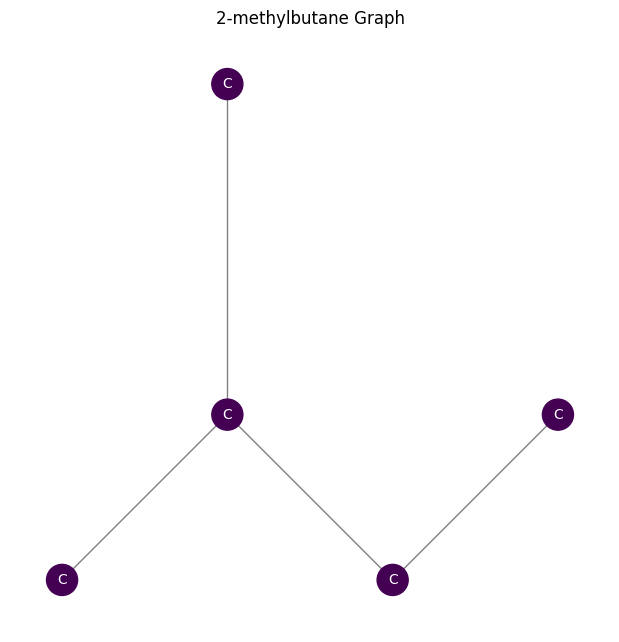


isopentane - CCC(C)C


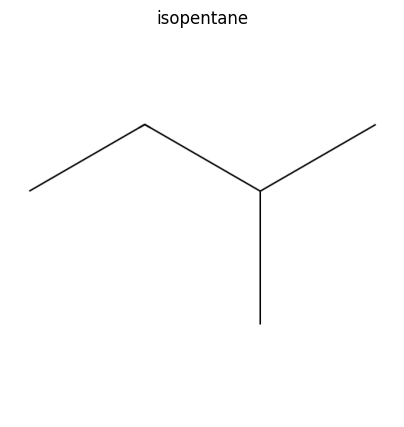

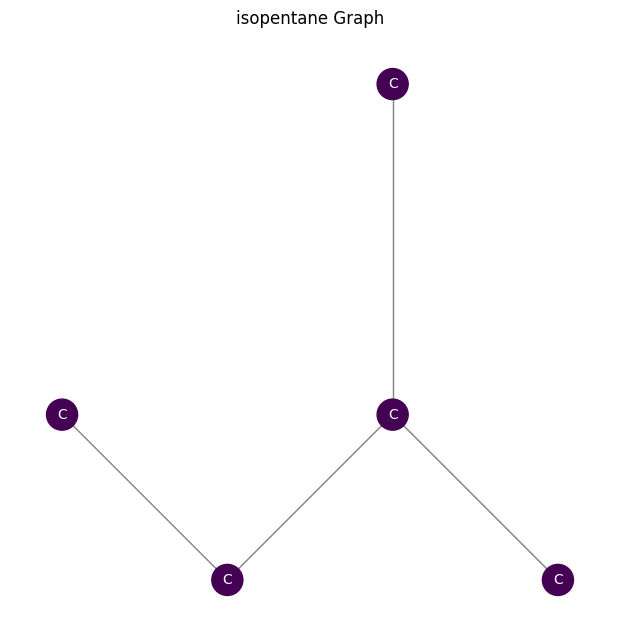


Non-isomorphic Molecules (Different Structures):

n-pentane - CCCCC


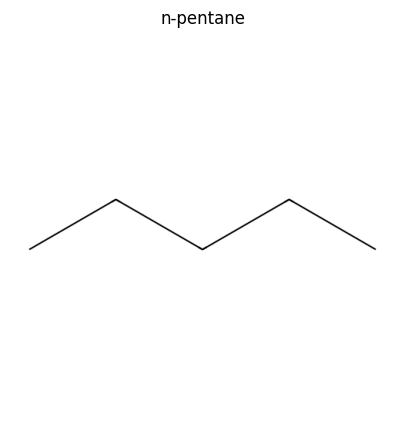

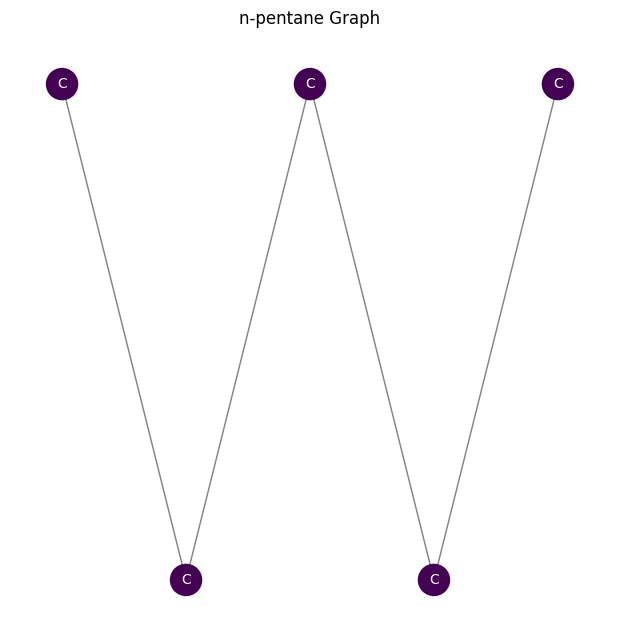


2-methylbutane - CC(C)CC


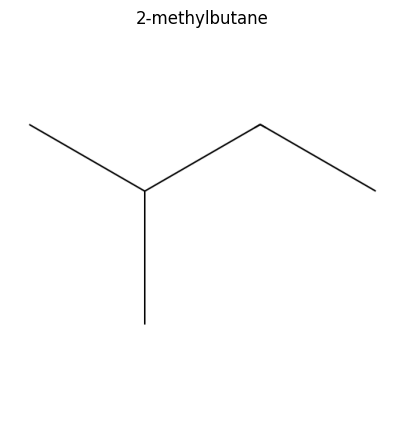

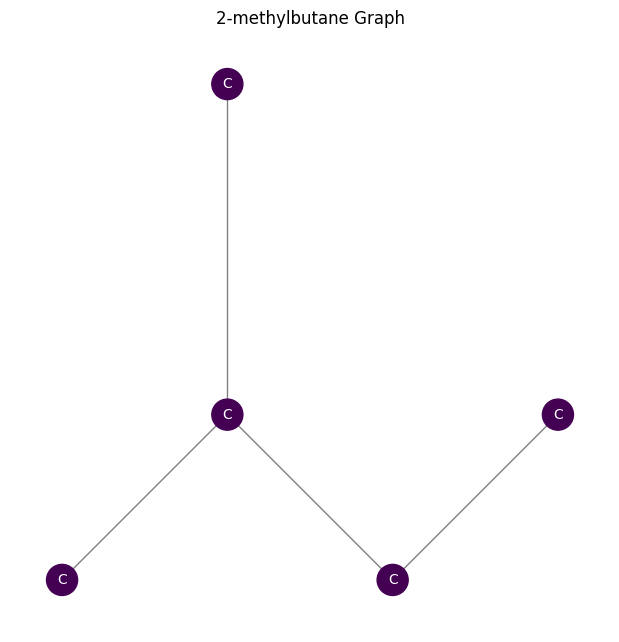

In [3]:
def mol_to_graph(smiles):
    """Convert a SMILES string to a PyTorch Geometric Data object"""
    mol = Chem.MolFromSmiles(smiles)

    # Get node features (atomic numbers as initial features)
    node_features = []
    for atom in mol.GetAtoms():
        features = [
            atom.GetAtomicNum(),
            atom.GetFormalCharge(),
            atom.GetNumExplicitHs(),
            atom.GetNumImplicitHs(),
            int(atom.GetIsAromatic()),
            atom.GetDegree()
        ]
        node_features.append(features)

    x = torch.tensor(node_features, dtype=torch.float)

    # Get edge indices
    edge_indices = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        # Add edges in both directions
        edge_indices.append([i, j])
        edge_indices.append([j, i])

    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Get edge features (bond types)
    edge_features = []
    for bond in mol.GetBonds():
        # Add features for both directions
        features = [bond.GetBondTypeAsDouble()]
        edge_features.append(features)
        edge_features.append(features)

    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

def visualize_molecule(smiles, title="Molecule"):
    """Visualize a molecule using RDKit"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    # Draw molecule
    fig, ax = plt.subplots(figsize=(5, 5))
    drawer = rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()

    # Convert the image data to a PIL Image
    pil_image = Image.open(io.BytesIO(img))

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def visualize_molecular_graph(smiles, title="Molecular Graph"):
    """Visualize a molecule as a graph using NetworkX"""
    mol = Chem.MolFromSmiles(smiles)
    AllChem.Compute2DCoords(mol)

    data = mol_to_graph(smiles)
    G = to_networkx(data, to_undirected=True)

    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, -pos[i].y)  # Flip y for better visualization

    plt.figure(figsize=(6, 6))

    # Get atom labels
    atom_labels = {i: atom.GetSymbol() for i, atom in enumerate(mol.GetAtoms())}

    # Get atom features for node coloring
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]

    # Draw the graph
    nx.draw(G, pos,
            labels=atom_labels,
            with_labels=True,
            node_color=atom_features,
            cmap=plt.cm.viridis,
            node_size=500,
            font_size=10,
            font_color='white',
            edge_color='gray')

    plt.title(title)
    plt.axis('off')
    plt.show()

# Let's understand isomorphism with some examples
isomorphic_pair = {
    "2-methylbutane": "CC(C)CC",
    "isopentane": "CCC(C)C"
}

non_isomorphic_pair = {
    "n-pentane": "CCCCC",
    "2-methylbutane": "CC(C)CC"
}

# Visualize isomorphic molecules
print("Isomorphic Molecules (Same Structure, Different Representation):")
for name, smiles in isomorphic_pair.items():
    print(f"\n{name} - {smiles}")
    visualize_molecule(smiles, f"{name}")
    visualize_molecular_graph(smiles, f"{name} Graph")

# Visualize non-isomorphic molecules
print("\nNon-isomorphic Molecules (Different Structures):")
for name, smiles in non_isomorphic_pair.items():
    print(f"\n{name} - {smiles}")
    visualize_molecule(smiles, f"{name}")
    visualize_molecular_graph(smiles, f"{name} Graph")

### Understanding Graph Isomorphism and WL Test


<ipython-input-4-eea2202e0ad3>:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


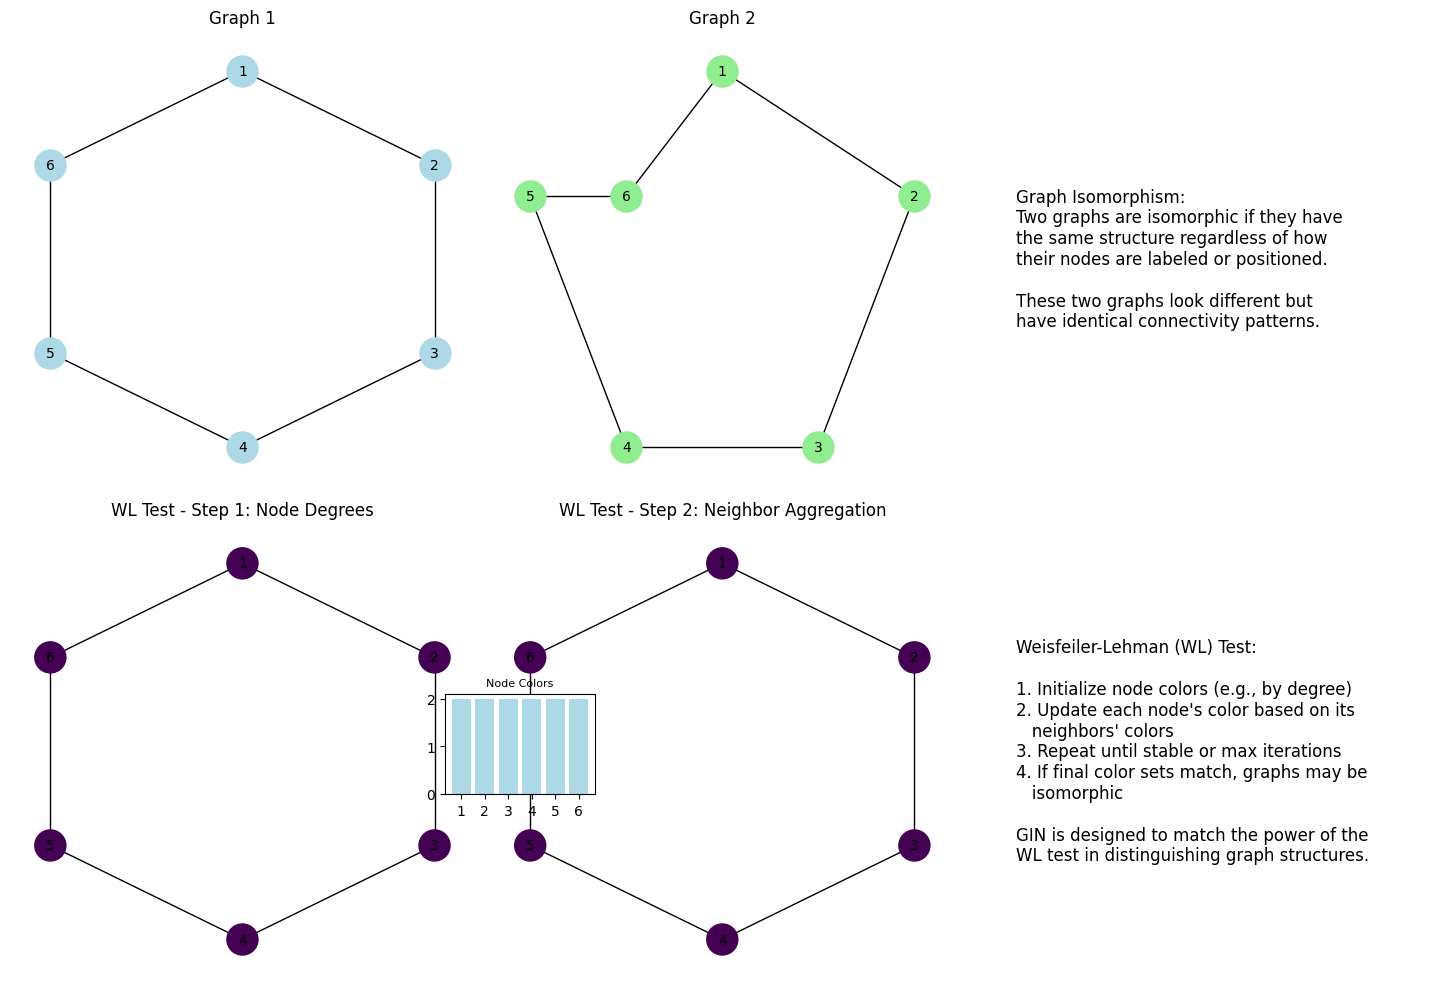

In [4]:
def visualize_isomorphism_concept():
    """Create a visual explanation of graph isomorphism and the WL test"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Create two isomorphic graphs
    G1 = nx.Graph()
    G1.add_nodes_from(range(1, 7))
    G1.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 1)])

    G2 = nx.Graph()
    G2.add_nodes_from(range(1, 7))
    G2.add_edges_from([(1, 6), (6, 5), (5, 4), (4, 3), (3, 2), (2, 1)])

    # Different node positioning to make them look different
    pos1 = {
        1: (0, 1),
        2: (0.866, 0.5),
        3: (0.866, -0.5),
        4: (0, -1),
        5: (-0.866, -0.5),
        6: (-0.866, 0.5)
    }

    pos2 = {
        1: (0, 1),
        2: (1, 0.5),
        3: (0.5, -0.5),
        4: (-0.5, -0.5),
        5: (-1, 0.5),
        6: (-0.5, 0.5)
    }

    # Draw the original graphs
    ax = axes[0, 0]
    nx.draw(G1, pos1, with_labels=True, node_color='lightblue', node_size=500, font_size=10, ax=ax)
    ax.set_title("Graph 1")

    ax = axes[0, 1]
    nx.draw(G2, pos2, with_labels=True, node_color='lightgreen', node_size=500, font_size=10, ax=ax)
    ax.set_title("Graph 2")

    # Create empty subplot for text
    ax = axes[0, 2]
    ax.axis('off')
    ax.text(0.1, 0.5, "Graph Isomorphism:\nTwo graphs are isomorphic if they have\nthe same structure regardless of how\ntheir nodes are labeled or positioned.\n\nThese two graphs look different but\nhave identical connectivity patterns.",
            fontsize=12, ha='left', va='center')

    # Now visualize WL test iterations
    # Iteration 1: Initialize with degree
    wl_colors1 = {n: G1.degree(n) for n in G1.nodes()}
    wl_colors2 = {n: G2.degree(n) for n in G2.nodes()}

    # Draw WL test step 1
    ax = axes[1, 0]
    nx.draw(G1, pos1, with_labels=True,
            node_color=[wl_colors1[n] for n in G1.nodes()],
            cmap=plt.cm.viridis,
            node_size=500, font_size=10, ax=ax)
    ax.set_title("WL Test - Step 1: Node Degrees")

    # Draw inset with color mapping
    inset_ax = fig.add_axes([0.3, 0.2, 0.1, 0.1])
    inset_ax.bar(wl_colors1.keys(), wl_colors1.values(), color='lightblue')
    inset_ax.set_xticks(list(wl_colors1.keys()))
    inset_ax.set_title("Node Colors", fontsize=8)

    # Iteration 2: Update with neighbor colors
    def wl_update(graph, colors):
        new_colors = {}
        for node in graph.nodes():
            # Get colors of neighbors
            neighbor_colors = [colors[neigh] for neigh in graph.neighbors(node)]
            # Sort for canonical representation
            neighbor_colors.sort()
            # Create new color from node color and neighbor colors
            new_colors[node] = (colors[node], tuple(neighbor_colors))
        return new_colors

    wl_colors1_step2 = wl_update(G1, wl_colors1)
    wl_colors2_step2 = wl_update(G2, wl_colors2)

    # Convert to integers for visualization
    unique_colors = list(set(wl_colors1_step2.values()))
    color_map = {color: i for i, color in enumerate(unique_colors)}

    mapped_colors1 = {n: color_map[wl_colors1_step2[n]] for n in G1.nodes()}
    mapped_colors2 = {n: color_map[wl_colors2_step2[n]] for n in G2.nodes()}

    # Draw WL test step 2
    ax = axes[1, 1]
    nx.draw(G1, pos1, with_labels=True,
            node_color=[mapped_colors1[n] for n in G1.nodes()],
            cmap=plt.cm.viridis,
            node_size=500, font_size=10, ax=ax)
    ax.set_title("WL Test - Step 2: Neighbor Aggregation")

    # Create empty subplot for WL explanation
    ax = axes[1, 2]
    ax.axis('off')
    ax.text(0.1, 0.5, "Weisfeiler-Lehman (WL) Test:\n\n1. Initialize node colors (e.g., by degree)\n2. Update each node's color based on its\n   neighbors' colors\n3. Repeat until stable or max iterations\n4. If final color sets match, graphs may be\n   isomorphic\n\nGIN is designed to match the power of the\nWL test in distinguishing graph structures.",
            fontsize=12, ha='left', va='center')

    plt.tight_layout()
    plt.show()

# Visualize the concept of graph isomorphism and the WL test
visualize_isomorphism_concept()

## 2. The Theory Behind Graph Isomorphism Networks (GIN)

GIN was designed to have the same discriminative power as the Weisfeiler-Lehman (WL) graph isomorphism test, which is a powerful approach for distinguishing non-isomorphic graphs.


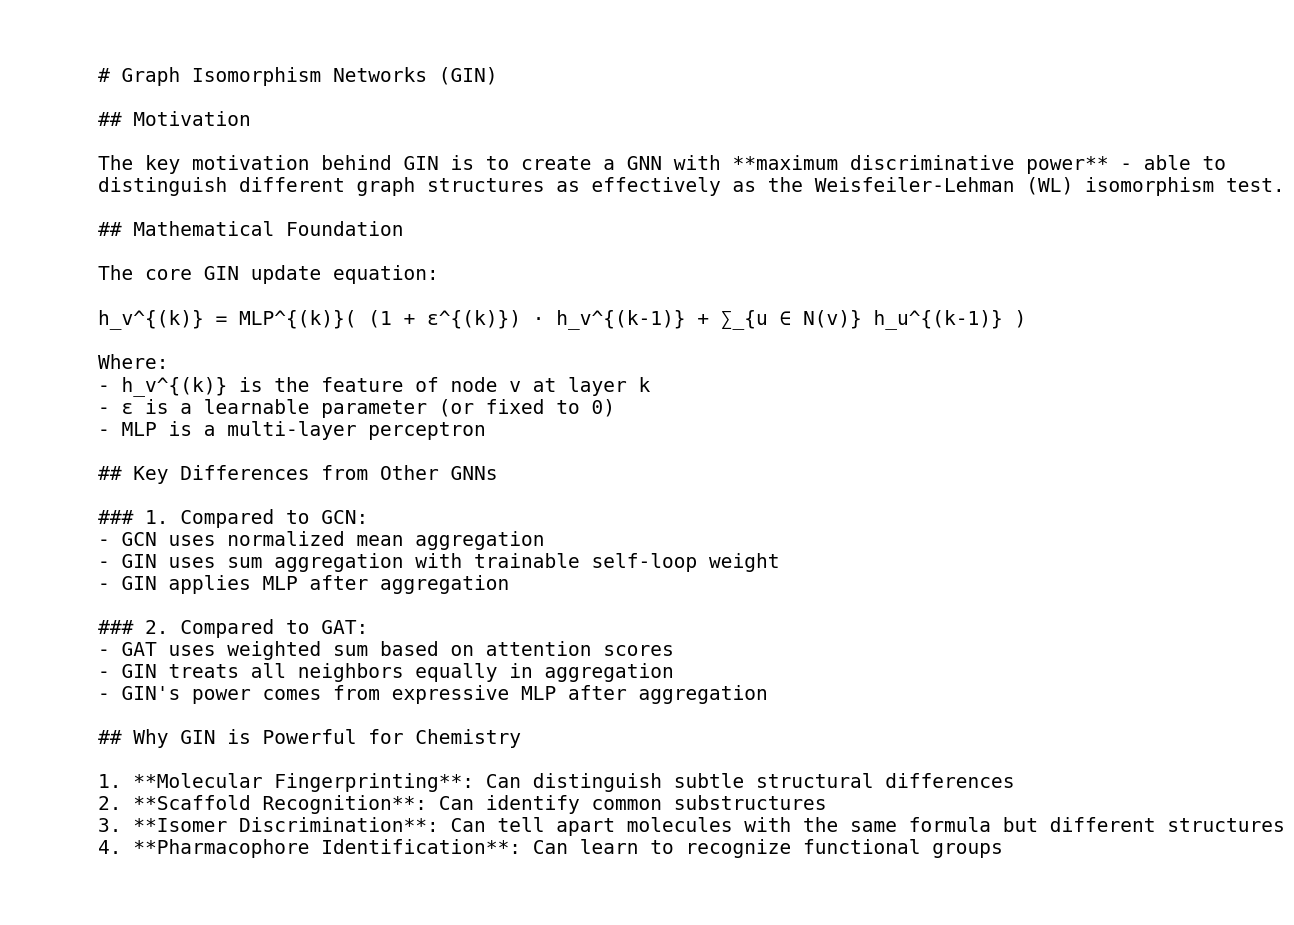

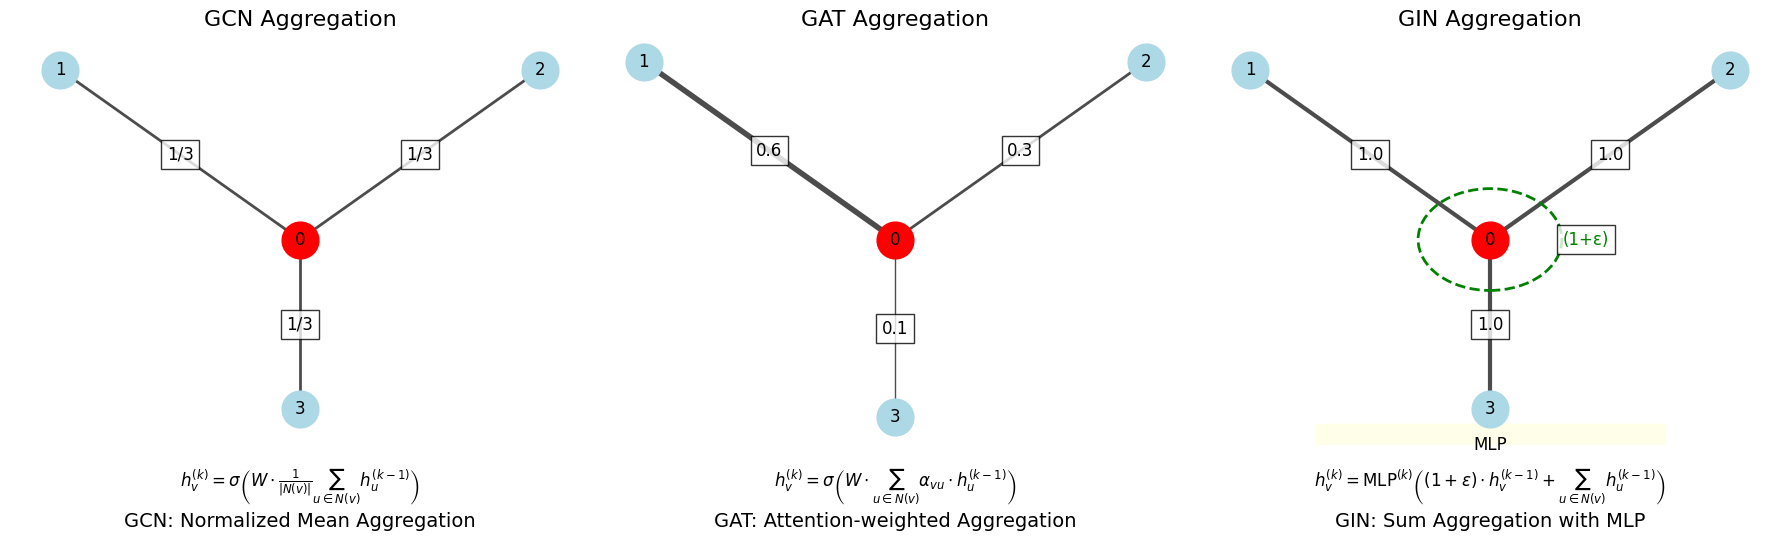

In [5]:
def explain_gin_vs_other_gnns():
    """Create a visual explanation of how GIN differs from other GNNs"""
    plt.figure(figsize=(12, 10))

    # Define example text
    gin_explanation = """
    # Graph Isomorphism Networks (GIN)

    ## Motivation

    The key motivation behind GIN is to create a GNN with **maximum discriminative power** - able to
    distinguish different graph structures as effectively as the Weisfeiler-Lehman (WL) isomorphism test.

    ## Mathematical Foundation

    The core GIN update equation:

    h_v^{(k)} = MLP^{(k)}( (1 + ε^{(k)}) · h_v^{(k-1)} + ∑_{u ∈ N(v)} h_u^{(k-1)} )

    Where:
    - h_v^{(k)} is the feature of node v at layer k
    - ε is a learnable parameter (or fixed to 0)
    - MLP is a multi-layer perceptron

    ## Key Differences from Other GNNs

    ### 1. Compared to GCN:
    - GCN uses normalized mean aggregation
    - GIN uses sum aggregation with trainable self-loop weight
    - GIN applies MLP after aggregation

    ### 2. Compared to GAT:
    - GAT uses weighted sum based on attention scores
    - GIN treats all neighbors equally in aggregation
    - GIN's power comes from expressive MLP after aggregation

    ## Why GIN is Powerful for Chemistry

    1. **Molecular Fingerprinting**: Can distinguish subtle structural differences
    2. **Scaffold Recognition**: Can identify common substructures
    3. **Isomer Discrimination**: Can tell apart molecules with the same formula but different structures
    4. **Pharmacophore Identification**: Can learn to recognize functional groups
    """

    plt.text(0.05, 0.5, gin_explanation, fontsize=14,
            verticalalignment='center', horizontalalignment='left',
            family='monospace', transform=plt.gca().transAxes)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

explain_gin_vs_other_gnns()

def visualize_gnn_aggregation_comparison():
    """Compare aggregation mechanisms in different GNNs"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Create a simple graph for demonstration
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([(0, 1), (0, 2), (0, 3)])

    # Define positions
    pos = {0: (0.5, 0.5), 1: (0, 1), 2: (1, 1), 3: (0.5, 0)}

    # GCN - Mean aggregation
    ax = axes[0]
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='red', node_size=700, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[1, 2, 3], node_color='lightblue', node_size=700, ax=ax)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Add explanation text
    ax.text(0.5, -0.1, r"$h_v^{(k)} = \sigma\left(W \cdot \frac{1}{|N(v)|} \sum_{u \in N(v)} h_u^{(k-1)}\right)$",
            ha='center', fontsize=12, transform=ax.transAxes)
    ax.text(0.5, -0.2, "GCN: Normalized Mean Aggregation", ha='center', fontsize=14, transform=ax.transAxes)

    # Add coefficients
    ax.text(0.25, 0.75, "1/3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.75, 0.75, "1/3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.5, 0.25, "1/3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ax.set_title("GCN Aggregation", fontsize=16)
    ax.axis('off')

    # GAT - Attention-weighted aggregation
    ax = axes[1]
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='red', node_size=700, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[1, 2, 3], node_color='lightblue', node_size=700, ax=ax)

    # Draw edges with different widths to represent attention
    edge_widths = [4, 2, 1]
    for i, (u, v) in enumerate([(0, 1), (0, 2), (0, 3)]):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=edge_widths[i], alpha=0.7, ax=ax)

    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Add explanation text
    ax.text(0.5, -0.1, r"$h_v^{(k)} = \sigma\left(W \cdot \sum_{u \in N(v)} \alpha_{vu} \cdot h_u^{(k-1)}\right)$",
            ha='center', fontsize=12, transform=ax.transAxes)
    ax.text(0.5, -0.2, "GAT: Attention-weighted Aggregation", ha='center', fontsize=14, transform=ax.transAxes)

    # Add coefficients
    ax.text(0.25, 0.75, "0.6", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.75, 0.75, "0.3", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.5, 0.25, "0.1", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    ax.set_title("GAT Aggregation", fontsize=16)
    ax.axis('off')

    # GIN - Sum aggregation with MLP
    ax = axes[2]
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color='red', node_size=700, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=[1, 2, 3], node_color='lightblue', node_size=700, ax=ax)
    nx.draw_networkx_edges(G, pos, width=3, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, ax=ax)

    # Add explanation text
    ax.text(0.5, -0.1, r"$h_v^{(k)} = \text{MLP}^{(k)}\left((1 + \epsilon) \cdot h_v^{(k-1)} + \sum_{u \in N(v)} h_u^{(k-1)}\right)$",
            ha='center', fontsize=12, transform=ax.transAxes)
    ax.text(0.5, -0.2, "GIN: Sum Aggregation with MLP", ha='center', fontsize=14, transform=ax.transAxes)

    # Add coefficients and highlight MLP
    ax.text(0.25, 0.75, "1.0", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.75, 0.75, "1.0", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.5, 0.25, "1.0", ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    # Add self-loop
    circle = plt.Circle((0.5, 0.5), 0.15, fill=False, linestyle='--', color='green', linewidth=2)
    ax.add_patch(circle)
    ax.text(0.7, 0.5, f"(1+ε)", ha='center', va='center', fontsize=12, color='green',
            bbox=dict(facecolor='white', alpha=0.8))

    # Add MLP
    rect = plt.Rectangle((0.2, -0.05), 0.6, 0.1, fill=True, color='lightyellow', alpha=0.7, transform=ax.transAxes)
    ax.add_patch(rect)
    ax.text(0.5, 0.0, "MLP", ha='center', va='center', fontsize=12, transform=ax.transAxes)

    ax.set_title("GIN Aggregation", fontsize=16)
    ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

# Compare the aggregation mechanisms of different GNNs
visualize_gnn_aggregation_comparison()